In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

MASK_VALUE = -1e18

class HAN(nn.Module):
    """Hierarchical Attention Network for document classification [1].
    
    References
    ----------
    [1] https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    
    """
    def __init__(self, V, E, C, h=50, L=25, T=50, bidirectional=True, dropout=0.5):
        super().__init__()
        """
        
        V  | Vocab size
        E  | Embedding dimension
        C  | Number of classes
        h  | Hidden dimension
        ------------------------
        B  | Batch size
        L  | Max no. of sentences in a document
        T  | Max no. of words in a sentence
        H  | 2*h or h depending on bidirectional
        
        """
        self.embed = nn.Embedding(V, E)
        self.word_encoder = nn.GRU(
            input_size=E,
            hidden_size=h,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.H = 2*h if bidirectional else h
        self.L = L
        self.T = T
        
        # word encoder + attention
        self.word_attention = nn.Parameter(torch.randn([self.H, 1]).float())
        # u_w in paper
        self.word_linear = nn.Linear(
            in_features=self.H,
            out_features=self.H
        )
        
        # sentence encoder + attention
        self.sentence_encoder = nn.GRU(
            input_size=self.H,
            hidden_size=h,
            bidirectional=bidirectional,
            batch_first=True
        )
        # u_s in paper
        self.sentence_attention = nn.Parameter(torch.randn([self.H, 1]).float())
        self.sentence_linear = nn.Linear(
            in_features=self.H,
            out_features=self.H
        )
        
        # output layers
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.H, C)
    
    def forward(self, x):
        B = x.shape[0]
        words_mask = x != 0                             # B x L x T
        # print("x", x.shape)
        
        # reshape x to represent words only
        x = x.view(B*self.L, self.T)                    # BL x T
        # reshape the mask as well
        words_mask = words_mask.view(B*self.L, self.T)  # BL x T
        x = self.embed(x)                               # BL x T x E
        
        # ===========================
        # word encoding and attention
        # ===========================
        h_it, _ = self.word_encoder(x)                  # BL x T x H 
        u_it = torch.tanh(self.word_linear(h_it))       # BL x T x H
        # reshape word_attention from H x 1 -> BL x H x 1
        u_w = self.word_attention.unsqueeze(0).expand(B*self.L, -1, -1)
        s_i = u_it.bmm(u_w)                             # (BL x T x H) x (BL x H x 1) -> BL x T x 1
        # apply mask
        words_mask = words_mask.unsqueeze(-1)
        s_i = s_i.masked_fill(~words_mask, MASK_VALUE)
        # attention vector
        a_it = torch.softmax(s_i, dim=1)                # BL x T x 1
        a_it = a_it.transpose(-1, -2)                   # BL x 1 x T
        x_ = a_it.bmm(h_it)                             # (BL x 1 x T) x (BL x T x H) -> BL x 1 x H
        # residual
        x = h_it.mean(dim=1).unsqueeze(dim=1) + x_
        
        # re-adjust x to be of shape: B x L x H
        x = x.squeeze(1).view(B, self.L, self.H)        # B x L x H
        
        # ===============================
        # sentence encoding and attention
        # ===============================
        h_i, _ = self.sentence_encoder(x)               # B x L x H
        u_i = torch.tanh(self.sentence_linear(h_i))     # B x L x H
        # reshape sentence_attention from H x 1 -> B x H x 1
        u_s = self.sentence_attention.unsqueeze(0).expand(B, -1, -1)
        v = u_i.bmm(u_s)                                # (B x L x H) x (B x H x 1) -> B X L X 1
        # get sentence mask
        words_mask = words_mask.view(B, self.L, -1)     # B x L x T
        # sentence padding is where all indicies sum up to 0
        sents_mask = words_mask.sum(-1) != 0            # B x L 
        sents_mask = sents_mask.unsqueeze(-1)           # B x L x 1
        # apply mask
        v = v.masked_fill(~sents_mask, MASK_VALUE)
        a_i = torch.softmax(v, dim=1) 
        x_ = a_i.transpose(-1, -2).bmm(h_i)             # (B x 1 x L) x (B x L x H) -> B x 1 x H
        # residual
        x = h_i.mean(dim=1).unsqueeze(dim=1) + x_
        x = x.squeeze(1)                                # B x H
        
        # output layer
        x = self.dropout(x)
        logits = self.linear(x)                         # B x H -> B x C
        
        return logits

In [0]:
class HierarchicalSelfAttention(nn.Module):
    """Hierarchical Attention Network for document classification [1].
    
    References
    ----------
    [1] https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    
    """
    
    def __init__(self, V, E, C, h=50, L=10, T=40, bidirectional=True, dropout=0.5):
        super().__init__()
        """
        
        V  | Vocab size
        E  | Embedding dimension
        C  | Number of classes
        h  | Hidden dimension
        ------------------------
        B  | Batch size
        L  | Max no. of sentences in a document
        T  | Max no. of words in a sentence
        H  | 2*h or h depending on bidirectional
        
        """
        self.embed = nn.Embedding(V, E)
        self.word_encoder = nn.GRU(
            input_size=E,
            hidden_size=h,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.H = 2*h if bidirectional else h
        self.L = L
        self.T = T
        
        # sentence encoder + attention
        self.sentence_encoder = nn.GRU(
            input_size=self.H,
            hidden_size=h,
            bidirectional=bidirectional,
            batch_first=True
        )
        
        # output layers
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.H, C)
    
    def forward(self, x):
        B = x.shape[0]
        # B x L x T
        words_mask = x != 0
        # reshape x to represent words only: BL x T
        x = x.view(B*self.L, self.T)
        # reshape the mask as well: BL x T
        words_mask = words_mask.view(B*self.L, self.T)
        
        # [in]: BL x T -> BL x T x E :[out]
        x = self.embed(x)
        
        # ===========================
        # word encoding and attention
        # ===========================
        # [in]: BL x T x E -> BL x T x H :[out]
        x, _ = self.word_encoder(x)
        
        # (BL x T x H) x (BL x H x T) -> BL x T x T
        attn_scores = x.bmm(x.transpose(-1, -2))
        # BL x T -> BL x T x T
        mask = words_mask.unsqueeze(-1).expand_as(attn_scores)
        attn_scores = attn_scores.masked_fill(~mask, MASK_VALUE)
        # BL x T x T
        attn = torch.softmax(attn_scores, dim=-1)
        
        # (BL x T x T) x (BL x T x H) -> BL x T x H
        x = x + attn.bmm(x)
        # BL x H
        x = x.mean(dim=1)
        # B x L x H
        x = x.view(B, self.L, -1)
        
        # ===============================
        # sentence encoding and attention
        # ===============================
        # [in]: B x L x H -> B x L x H :[out]
        x, _ = self.sentence_encoder(x)
        
        # (B x L x H) x (B x H x L) -> B x L x L
        attn_scores = x.bmm(x.transpose(-1, -2))
        # BL x T -> B x L x T -> B x L
        sents_mask = words_mask.view(B, self.L, -1).sum(-1) != 0
        # B x L -> B x L x H
        sents_mask = sents_mask.unsqueeze(-1).expand(B, self.L, -1)
        attn_scores = attn_scores.masked_fill(~sents_mask, MASK_VALUE)
        # B x L x L
        attn = torch.softmax(attn_scores, dim=-1)
        
        # (B x L x L) x (B x L x H) -> B x L x H
        x = x + attn.bmm(x)
        # B x H
        x = x.mean(dim=1)
        
        # output layer
        x = self.dropout(x)
        # [in]: B x H -> B x C :[out]
        logits = self.linear(x)
        
        return logits


In [0]:
import os
import pickle as pkl

import torch
import torch.nn as nn

def batched_data(*tensors, batch_size=64):
    data = TensorDataset(*tensors)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

# return (Xtrain, ytrain, ids_train), (Xdev, ydev, ids_dev), (Xtest, ids_test), word2index
def get_data(train_file="./train_tensor_256_0501.pkl", 
             dev_file="./dev_tensor_256_0501.pkl",
             test_file="./test_tensor_256_0501.pkl",
             word2index_file="./word2index_256_0501.pkl"):

    (Xtrain, ytrain, ids_train) = pkl.load(open(train_file, "rb"))
    (Xdev, ydev, ids_dev) = pkl.load(open(dev_file, "rb"))
    (Xtest, ytest, ids_test) = pkl.load(open(test_file, "rb"))
    word2index = pkl.load(open(word2index_file, "rb"))
    return (Xtrain, ytrain, ids_train), (Xdev, ydev, ids_dev), (Xtest, ids_test), word2index

train, _, _, _ = get_data()
print(train[0].shape, train[1].shape, train[2].shape)

torch.Size([18000, 250]) torch.Size([18000, 300]) torch.Size([18000])


In [0]:
from torch import optim
# from loss import BalancedBCEWithLogitsLoss
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm, trange

def train(train_dataloader, dev_dataloader, model, 
          epochs, lr, device, grad_clip=None, 
          model_save_fname="model.pt"):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    steps = 0
    best_fmicro = None
    last_fmicro = None
    loss_fct = BCEWithLogitsLoss()
    evals = []
    
    try:
        for epoch_no in trange(epochs, desc="Epoch"):
            model.train()
            tr_loss = 0
            nb_tr_examples, nb_tr_steps = 0, 0
            
            for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
                batch = tuple(t.to(device) for t in batch)
                inputs, labels, ids = batch
                
                logits = model(inputs)
                loss = loss_fct(logits, labels)
                loss.backward()
                
                tr_loss += loss.item()
                nb_tr_examples += inputs.size(0)
                nb_tr_steps += 1
                
                if grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                
                optimizer.step()
                optimizer.zero_grad()
                steps += 1 

                # print(labels, logits)
            
            score, eval_data, eval_add = evaluate(dev_dataloader, model, device)
            
            if not best_fmicro or score < best_fmicro:
                torch.save(model.state_dict(), "./{}".format(model_save_fname))
                best_fmicro = score
            print("train loss", tr_loss / len(train_dataloader))
            evals.append((epoch_no, score, eval_data, eval_add, tr_loss / len(train_dataloader)))
    
    except KeyboardInterrupt:
        print('-' * 89)
        print('Exiting from training early')
    
    return evals

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

def evaluate(dataloader, model, device, no_labels=False):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    logits = []
    preds = []
    labels = []
    ids = []
    avg_loss = 0.
    loss_fct = BCEWithLogitsLoss()

    avg_acc_8 = 0.
    avg_acc_15 = 0.
    
    def append(all_tensors, batch_tensor):
        if len(all_tensors) == 0:
            all_tensors.append(batch_tensor)
        else:
            all_tensors[0] = np.append(all_tensors[0], batch_tensor, axis=0)
        return all_tensors
    
    def detach(tensor, dtype=None):
        if dtype:
            return tensor.detach().cpu().numpy().astype(dtype)
        else:
            return tensor.detach().cpu().numpy()
    
    with torch.no_grad():  
        for batch in tqdm(dataloader, desc="Iteration"):
            batch = tuple(t.to(device) for t in batch)
            if no_labels:
                b_inputs, b_ids = batch
            else:
                b_inputs, b_labels, b_ids = batch

            b_logits = model(b_inputs)
            if not no_labels:
                loss = loss_fct(b_logits, b_labels)
                avg_loss += loss.item()

            b_prob = torch.sigmoid(b_logits) #.detach().cpu().numpy();
            b_preds = (torch.sigmoid(b_logits).detach().cpu().numpy() >= 0.5).astype(int)
            b_logits = detach(b_logits, float)
            if not no_labels:
                b_labels = detach(b_labels, int)
            b_ids = detach(b_ids, int)
            
            preds = append(preds, b_preds)
            logits = append(logits, b_logits)
            if not no_labels:
                labels = append(labels, b_labels)
            ids = append(ids, b_ids)

            mlb = MultiLabelBinarizer(classes=[i for i in range(300)])
            _, top_8 = torch.topk(b_prob, 8)
            top_8 = top_8.detach().cpu().numpy() # (64, 8)
            _, top_15 = torch.topk(b_prob, 15)
            top_15 = top_15.detach().cpu().numpy()

            mlb_top_8, mlb_top_15 = mlb.fit_transform(top_8), mlb.fit_transform(top_15)
            mlb_top_8 = np.where(mlb_top_8==0, -1, mlb_top_8) 
            mlb_top_15 = np.where(mlb_top_15==0, -1, mlb_top_15) 

            b_acc_8 = np.sum(mlb_top_8 == b_labels) / (mlb_top_8.shape[0] * 8)
            b_acc_15 = np.sum(mlb_top_15 == b_labels) / (mlb_top_15.shape[0] * 15)
            avg_acc_8 += b_acc_8
            avg_acc_15 += b_acc_15
            print("acc@8/15: ", b_acc_8, b_acc_15)
    
    preds = preds[0]
    logits = logits[0]
    if not no_labels:
        labels = labels[0]
        avg_loss /= len(dataloader)
        avg_acc_8 /= len(dataloader)
        avg_acc_15 /= len(dataloader)
    ids = ids[0]
    
    if not no_labels:
        score = f1_score(y_true=labels, y_pred=preds, average='micro')
        f1_macro = f1_score(y_true=labels, y_pred=preds, average='macro')
        precision = precision_score(y_true=labels, y_pred=preds, average='micro')
        recall = recall_score(y_true=labels, y_pred=preds, average='micro')
        print("\nEvaluation - loss: {:.6f}  f1: {:.4f}%\n".format(avg_loss, score))
        print("avg_acc", avg_acc_8, avg_acc_15)
        print("f1_macro", f1_macro)
    else:
        score = 0.
    
    return score, (logits, preds, labels, ids, avg_loss), (f1_macro, precision, recall, avg_acc_8, avg_acc_15)

In [0]:
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def main(train_file="", dev_file="", model_name="han", lang="en",
         batch_size=64, max_seq_len=256, embed_dim=768, 
         epochs=50, lr=0.001, load_pretrain_ft=True, 
         load_pretrain_pubmed=False, pretrain_file="embedding_word_0506.pkl", 
         hidden_dim=300, max_sents_in_doc=8, max_words_in_sent=32, 
         as_heirarchy=True, bidirectional=True):

    train_data, dev_data, test_data, word2index = get_data() 
    # training data
    Xtrain, ytrain, ids_train = train_data
    Xtrain = Xtrain.reshape(-1, max_sents_in_doc, max_words_in_sent)
    print("train shape", Xtrain.shape, ytrain.shape, ids_train.shape)
    
    vocab_size = len(word2index)
    num_classes = ytrain[0].shape[0]
    print(vocab_size, num_classes)
    
    # dev data
    Xdev, ydev, ids_dev = dev_data
    Xdev = Xdev.reshape(-1, max_sents_in_doc, max_words_in_sent)
    print("dev shape", Xdev.shape, ydev.shape, ids_dev.shape)

    train_dataloader = batched_data(Xtrain, ytrain, ids_train, batch_size=batch_size)
    dev_dataloader = batched_data(Xdev, ydev, ids_dev, batch_size=batch_size)

    if load_pretrain_ft and pretrain_file:
        embed_matrix =  pkl.load(open(pretrain_file, 'rb')) # load_ft_embeds(word2index, embed_dim, pretrain_file)
    
    # model = HAN(vocab_size, embed_dim, num_classes, 
    #             h=hidden_dim, L=max_sents_in_doc, 
    #             T=max_words_in_sent, bidirectional=bidirectional)
    
    model = HierarchicalSelfAttention(vocab_size, embed_dim, num_classes, 
                h=hidden_dim, L=max_sents_in_doc, 
                T=max_words_in_sent, bidirectional=bidirectional)
    
    # print(embed_matrix.shape)
    if (load_pretrain_ft or load_pretrain_pubmed) and pretrain_file:
        model.embed.weight.data.copy_(torch.from_numpy(embed_matrix))
    model = model.to(device)
    print(model)

    model_save_fname = "./{}_{}.pt".format(lang, model_name)
    
    evals = train(train_dataloader, dev_dataloader, model, epochs, lr, 
          device=device, grad_clip=None, model_save_fname=model_save_fname)
    
    _, (_, preds, _, ids, _), _ = evaluate(dev_dataloader, model, device)
    
    return model, model_save_fname, preds, ids, evals
  
model, model_save_fname, dev_preds, preds_ids, evals = main()
torch.save(model.state_dict(), model_save_fname)

Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

train shape torch.Size([18000, 8, 32]) torch.Size([18000, 300]) torch.Size([18000])
10000 300
dev shape torch.Size([1000, 8, 32]) torch.Size([1000, 300]) torch.Size([1000])
HierarchicalSelfAttention(
  (embed): Embedding(10000, 768)
  (word_encoder): GRU(768, 300, batch_first=True, bidirectional=True)
  (sentence_encoder): GRU(600, 300, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=600, out_features=300, bias=True)
)



Iteration: 100%|██████████| 282/282 [00:23<00:00, 11.87it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 36.68it/s]

acc@8/15:  0.2265625 0.16979166666666667
acc@8/15:  0.2421875 0.17604166666666668
acc@8/15:  0.234375 0.18020833333333333
acc@8/15:  0.22265625 0.18541666666666667
acc@8/15:  0.240234375 0.17708333333333334
acc@8/15:  0.224609375 0.18229166666666666
acc@8/15:  0.244140625 0.19583333333333333
acc@8/15:  0.220703125 0.171875



Iteration: 100%|██████████| 16/16 [00:00<00:00, 36.34it/s]

acc@8/15:  0.234375 0.18541666666666667
acc@8/15:  0.228515625 0.17604166666666668
acc@8/15:  0.208984375 0.1625
acc@8/15:  0.232421875 0.18229166666666666
acc@8/15:  0.26171875 0.19375
acc@8/15:  0.185546875 0.16041666666666668
acc@8/15:  0.232421875 0.190625
acc@8/15:  0.234375 0.17333333333333334



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Iteration:   0%|          | 0/282 [00:00<?, ?it/s]


Evaluation - loss: 0.116545  f1: 0.0000%

avg_acc 0.2296142578125 0.1789322916666667
f1_macro 0.0
train loss 0.13109004690397716



Iteration: 100%|██████████| 282/282 [00:24<00:00, 11.70it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 37.20it/s]

acc@8/15:  0.349609375 0.23958333333333334
acc@8/15:  0.328125 0.24583333333333332
acc@8/15:  0.32421875 0.22604166666666667
acc@8/15:  0.337890625 0.24479166666666666
acc@8/15:  0.298828125 0.21041666666666667
acc@8/15:  0.328125 0.240625
acc@8/15:  0.30859375 0.225
acc@8/15:  0.287109375 0.240625



Iteration: 100%|██████████| 16/16 [00:00<00:00, 36.47it/s]

acc@8/15:  0.3359375 0.246875
acc@8/15:  0.34765625 0.24583333333333332
acc@8/15:  0.33203125 0.24270833333333333
acc@8/15:  0.30859375 0.23020833333333332
acc@8/15:  0.349609375 0.246875
acc@8/15:  0.3515625 0.2677083333333333
acc@8/15:  0.365234375 0.2552083333333333
acc@8/15:  0.284375 0.21166666666666667



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]


Evaluation - loss: 0.103208  f1: 0.1387%

avg_acc 0.32734375 0.23875000000000002
f1_macro 0.013541352992431633
train loss 0.11104479516651614



Iteration: 100%|██████████| 282/282 [00:24<00:00, 11.60it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 36.24it/s]

acc@8/15:  0.287109375 0.21875
acc@8/15:  0.345703125 0.253125
acc@8/15:  0.41796875 0.29791666666666666
acc@8/15:  0.3828125 0.290625
acc@8/15:  0.3515625 0.23958333333333334
acc@8/15:  0.330078125 0.24270833333333333
acc@8/15:  0.337890625 0.2520833333333333
acc@8/15:  0.298828125 0.22291666666666668



Iteration: 100%|██████████| 16/16 [00:00<00:00, 35.82it/s]

acc@8/15:  0.322265625 0.23125
acc@8/15:  0.30859375 0.23645833333333333
acc@8/15:  0.296875 0.22083333333333333
acc@8/15:  0.31640625 0.24166666666666667
acc@8/15:  0.326171875 0.23854166666666668
acc@8/15:  0.369140625 0.25729166666666664
acc@8/15:  0.251953125 0.19479166666666667
acc@8/15:  0.3125 0.22333333333333333



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]


Evaluation - loss: 0.101624  f1: 0.1245%

avg_acc 0.3284912109375 0.24136718750000002
f1_macro 0.011166123924516897
train loss 0.10570757112181778



Iteration: 100%|██████████| 282/282 [00:24<00:00, 11.46it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.81it/s]

acc@8/15:  0.296875 0.21041666666666667
acc@8/15:  0.296875 0.23125
acc@8/15:  0.29296875 0.23020833333333332
acc@8/15:  0.337890625 0.2375
acc@8/15:  0.2734375 0.23125
acc@8/15:  0.333984375 0.24583333333333332
acc@8/15:  0.306640625 0.221875
acc@8/15:  0.37890625 0.2635416666666667



Iteration: 100%|██████████| 16/16 [00:00<00:00, 35.23it/s]

acc@8/15:  0.39453125 0.2833333333333333
acc@8/15:  0.318359375 0.23854166666666668
acc@8/15:  0.373046875 0.26979166666666665
acc@8/15:  0.328125 0.225
acc@8/15:  0.369140625 0.2791666666666667
acc@8/15:  0.36328125 0.26458333333333334
acc@8/15:  0.390625 0.28125
acc@8/15:  0.35 0.235



Iteration:   1%|          | 2/282 [00:00<00:23, 11.74it/s]


Evaluation - loss: 0.100109  f1: 0.1531%

avg_acc 0.33779296875 0.2467838541666667
f1_macro 0.017066528709951723
train loss 0.10381032418169028



Iteration: 100%|██████████| 282/282 [00:24<00:00, 11.40it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 35.03it/s]

acc@8/15:  0.33203125 0.23125
acc@8/15:  0.341796875 0.25729166666666664
acc@8/15:  0.306640625 0.22916666666666666
acc@8/15:  0.345703125 0.234375
acc@8/15:  0.34375 0.24895833333333334
acc@8/15:  0.365234375 0.25416666666666665
acc@8/15:  0.34765625 0.25833333333333336



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.92it/s]

acc@8/15:  0.361328125 0.271875
acc@8/15:  0.34375 0.25833333333333336
acc@8/15:  0.341796875 0.26145833333333335
acc@8/15:  0.357421875 0.265625
acc@8/15:  0.296875 0.22395833333333334
acc@8/15:  0.365234375 0.2604166666666667
acc@8/15:  0.33203125 0.2635416666666667



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.36328125 0.2677083333333333
acc@8/15:  0.334375 0.225

Evaluation - loss: 0.099673  f1: 0.1744%

avg_acc 0.342431640625 0.2507161458333333
f1_macro 0.02080648220180171
train loss 0.1016839344503609



Iteration: 100%|██████████| 282/282 [00:24<00:00, 11.28it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.27it/s]

acc@8/15:  0.33203125 0.2520833333333333
acc@8/15:  0.326171875 0.23854166666666668
acc@8/15:  0.349609375 0.25416666666666665
acc@8/15:  0.32421875 0.23854166666666668
acc@8/15:  0.33203125 0.23333333333333334
acc@8/15:  0.330078125 0.2625
acc@8/15:  0.34765625 0.25625



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 33.66it/s]

acc@8/15:  0.328125 0.2375
acc@8/15:  0.328125 0.24895833333333334
acc@8/15:  0.32421875 0.23854166666666668
acc@8/15:  0.318359375 0.246875
acc@8/15:  0.40234375 0.2864583333333333
acc@8/15:  0.39453125 0.2864583333333333
acc@8/15:  0.3671875 0.2604166666666667



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.296875 0.22395833333333334
acc@8/15:  0.38125 0.28

Evaluation - loss: 0.100438  f1: 0.1554%

avg_acc 0.34267578125 0.25278645833333335
f1_macro 0.021693861621198796
train loss 0.09986721745408172



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.19it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.06it/s]

acc@8/15:  0.359375 0.2604166666666667
acc@8/15:  0.328125 0.24791666666666667
acc@8/15:  0.341796875 0.26145833333333335
acc@8/15:  0.330078125 0.23854166666666668
acc@8/15:  0.310546875 0.234375
acc@8/15:  0.330078125 0.2520833333333333
acc@8/15:  0.375 0.25625
acc@8/15:  0.3125 0.24583333333333332



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.38it/s]


acc@8/15:  0.375 0.27395833333333336
acc@8/15:  0.357421875 0.25833333333333336
acc@8/15:  0.345703125 0.24583333333333332
acc@8/15:  0.353515625 0.2677083333333333
acc@8/15:  0.330078125 0.24895833333333334
acc@8/15:  0.384765625 0.29270833333333335
acc@8/15:  0.283203125 0.22708333333333333
acc@8/15:  0.309375 0.22833333333333333


Iteration:   1%|          | 2/282 [00:00<00:24, 11.53it/s]


Evaluation - loss: 0.098762  f1: 0.1616%

avg_acc 0.33916015625 0.2524869791666666
f1_macro 0.023549175487776026
train loss 0.0985090637724873



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.17it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.40it/s]

acc@8/15:  0.37109375 0.27395833333333336
acc@8/15:  0.3046875 0.228125
acc@8/15:  0.357421875 0.259375
acc@8/15:  0.345703125 0.259375
acc@8/15:  0.36328125 0.26666666666666666
acc@8/15:  0.38671875 0.275
acc@8/15:  0.357421875 0.25625
acc@8/15:  0.37109375 0.26979166666666665



Iteration: 100%|██████████| 16/16 [00:00<00:00, 35.19it/s]

acc@8/15:  0.369140625 0.27395833333333336
acc@8/15:  0.310546875 0.25833333333333336
acc@8/15:  0.37109375 0.28541666666666665
acc@8/15:  0.322265625 0.23125
acc@8/15:  0.2890625 0.21458333333333332
acc@8/15:  0.32421875 0.23020833333333332
acc@8/15:  0.326171875 0.24583333333333332
acc@8/15:  0.340625 0.2633333333333333


Iteration:   1%|          | 2/282 [00:00<00:23, 11.81it/s]


Evaluation - loss: 0.098653  f1: 0.1966%

avg_acc 0.3444091796875 0.2557161458333333
f1_macro 0.028607036774734636
train loss 0.09685052180966587



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.22it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.26it/s]

acc@8/15:  0.353515625 0.265625
acc@8/15:  0.3359375 0.24895833333333334
acc@8/15:  0.369140625 0.2677083333333333
acc@8/15:  0.375 0.2760416666666667
acc@8/15:  0.330078125 0.24791666666666667
acc@8/15:  0.40234375 0.3
acc@8/15:  0.3203125 0.23125



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.50it/s]

acc@8/15:  0.275390625 0.20104166666666667
acc@8/15:  0.3359375 0.24166666666666667
acc@8/15:  0.333984375 0.246875
acc@8/15:  0.326171875 0.23958333333333334
acc@8/15:  0.400390625 0.2989583333333333
acc@8/15:  0.353515625 0.2604166666666667
acc@8/15:  0.40625 0.2833333333333333



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.34375 0.25625
acc@8/15:  0.31875 0.24

Evaluation - loss: 0.098654  f1: 0.1992%

avg_acc 0.348779296875 0.2566015625
f1_macro 0.033324302521578315
train loss 0.09532795738138206



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.18it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.61it/s]

acc@8/15:  0.353515625 0.25833333333333336
acc@8/15:  0.32421875 0.23645833333333333
acc@8/15:  0.3203125 0.23854166666666668
acc@8/15:  0.4140625 0.30104166666666665
acc@8/15:  0.31640625 0.24270833333333333
acc@8/15:  0.33984375 0.253125
acc@8/15:  0.34765625 0.259375
acc@8/15:  0.341796875 0.246875



Iteration: 100%|██████████| 16/16 [00:00<00:00, 35.14it/s]

acc@8/15:  0.34375 0.2635416666666667
acc@8/15:  0.3828125 0.28541666666666665
acc@8/15:  0.36328125 0.259375
acc@8/15:  0.330078125 0.24270833333333333
acc@8/15:  0.357421875 0.26145833333333335
acc@8/15:  0.337890625 0.24791666666666667
acc@8/15:  0.326171875 0.24375
acc@8/15:  0.35 0.2633333333333333



Iteration:   1%|          | 2/282 [00:00<00:24, 11.55it/s]


Evaluation - loss: 0.098577  f1: 0.2202%

avg_acc 0.346826171875 0.25649739583333336
f1_macro 0.03533205027100767
train loss 0.09361086273235632



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.16it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.78it/s]

acc@8/15:  0.35546875 0.271875
acc@8/15:  0.34765625 0.2708333333333333
acc@8/15:  0.349609375 0.25729166666666664
acc@8/15:  0.392578125 0.26875
acc@8/15:  0.296875 0.22395833333333334
acc@8/15:  0.37890625 0.278125
acc@8/15:  0.318359375 0.23125



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.14it/s]

acc@8/15:  0.3203125 0.25
acc@8/15:  0.36328125 0.259375
acc@8/15:  0.3359375 0.24583333333333332
acc@8/15:  0.400390625 0.28541666666666665
acc@8/15:  0.369140625 0.26875
acc@8/15:  0.341796875 0.23854166666666668
acc@8/15:  0.33984375 0.2552083333333333



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.31640625 0.23854166666666668
acc@8/15:  0.30625 0.22833333333333333

Evaluation - loss: 0.099232  f1: 0.2009%

avg_acc 0.34580078125 0.2545052083333333
f1_macro 0.0335620198724705
train loss 0.09203003500158904



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.19it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 36.32it/s]

acc@8/15:  0.326171875 0.25
acc@8/15:  0.357421875 0.26666666666666666
acc@8/15:  0.32421875 0.240625
acc@8/15:  0.294921875 0.234375
acc@8/15:  0.373046875 0.259375
acc@8/15:  0.376953125 0.28125
acc@8/15:  0.34375 0.2552083333333333



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.94it/s]

acc@8/15:  0.333984375 0.24895833333333334
acc@8/15:  0.31640625 0.23229166666666667
acc@8/15:  0.353515625 0.2677083333333333
acc@8/15:  0.3359375 0.23645833333333333
acc@8/15:  0.337890625 0.23645833333333333
acc@8/15:  0.361328125 0.27395833333333336
acc@8/15:  0.341796875 0.24791666666666667



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.35546875 0.26145833333333335
acc@8/15:  0.35625 0.2683333333333333

Evaluation - loss: 0.100176  f1: 0.2197%

avg_acc 0.34306640625 0.25381510416666664
f1_macro 0.035517794357309666
train loss 0.09045395685742932



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.16it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.17it/s]

acc@8/15:  0.388671875 0.278125
acc@8/15:  0.365234375 0.26145833333333335
acc@8/15:  0.3515625 0.2625
acc@8/15:  0.361328125 0.26875
acc@8/15:  0.306640625 0.23333333333333334
acc@8/15:  0.3515625 0.25729166666666664
acc@8/15:  0.310546875 0.24479166666666666
acc@8/15:  0.341796875 0.25625



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.95it/s]

acc@8/15:  0.345703125 0.27395833333333336
acc@8/15:  0.3359375 0.25729166666666664
acc@8/15:  0.328125 0.2604166666666667
acc@8/15:  0.33984375 0.2552083333333333
acc@8/15:  0.33203125 0.24479166666666666
acc@8/15:  0.306640625 0.22395833333333334
acc@8/15:  0.3046875 0.23229166666666667



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.31875 0.23833333333333334

Evaluation - loss: 0.100812  f1: 0.2110%

avg_acc 0.33681640625 0.253046875
f1_macro 0.036941040643149584
train loss 0.08884221986464574



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.17it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.21it/s]

acc@8/15:  0.345703125 0.2552083333333333
acc@8/15:  0.318359375 0.253125
acc@8/15:  0.375 0.2552083333333333
acc@8/15:  0.345703125 0.2520833333333333
acc@8/15:  0.365234375 0.26979166666666665
acc@8/15:  0.291015625 0.23333333333333334
acc@8/15:  0.333984375 0.25625
acc@8/15:  0.279296875 0.21875



Iteration: 100%|██████████| 16/16 [00:00<00:00, 35.21it/s]

acc@8/15:  0.35546875 0.24791666666666667
acc@8/15:  0.328125 0.24895833333333334
acc@8/15:  0.357421875 0.2625
acc@8/15:  0.333984375 0.25625
acc@8/15:  0.388671875 0.2875
acc@8/15:  0.369140625 0.2760416666666667
acc@8/15:  0.35546875 0.25833333333333336
acc@8/15:  0.296875 0.22666666666666666


Iteration:   1%|          | 2/282 [00:00<00:24, 11.62it/s]


Evaluation - loss: 0.100665  f1: 0.2222%

avg_acc 0.3399658203125 0.2536197916666667
f1_macro 0.04299268493395499
train loss 0.08713129276396535



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.21it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.59it/s]

acc@8/15:  0.275390625 0.2
acc@8/15:  0.3046875 0.23645833333333333
acc@8/15:  0.34765625 0.2552083333333333
acc@8/15:  0.36328125 0.2708333333333333
acc@8/15:  0.357421875 0.26145833333333335
acc@8/15:  0.337890625 0.24583333333333332
acc@8/15:  0.34765625 0.24375
acc@8/15:  0.302734375 0.234375



Iteration: 100%|██████████| 16/16 [00:00<00:00, 35.25it/s]

acc@8/15:  0.349609375 0.2625
acc@8/15:  0.373046875 0.28020833333333334
acc@8/15:  0.34375 0.25833333333333336
acc@8/15:  0.32421875 0.253125
acc@8/15:  0.326171875 0.24166666666666667
acc@8/15:  0.390625 0.2760416666666667
acc@8/15:  0.3203125 0.240625
acc@8/15:  0.340625 0.235



Iteration:   1%|          | 2/282 [00:00<00:24, 11.60it/s]


Evaluation - loss: 0.102500  f1: 0.2288%

avg_acc 0.3378173828125 0.24971354166666665
f1_macro 0.045809138959342015
train loss 0.08549955643132223



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.15it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 35.40it/s]

acc@8/15:  0.322265625 0.24270833333333333
acc@8/15:  0.322265625 0.246875
acc@8/15:  0.39453125 0.290625
acc@8/15:  0.3125 0.225
acc@8/15:  0.333984375 0.26666666666666666
acc@8/15:  0.341796875 0.24895833333333334
acc@8/15:  0.330078125 0.23854166666666668



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.41it/s]

acc@8/15:  0.349609375 0.2677083333333333
acc@8/15:  0.30078125 0.23125
acc@8/15:  0.3203125 0.24583333333333332
acc@8/15:  0.314453125 0.23541666666666666
acc@8/15:  0.322265625 0.24375
acc@8/15:  0.38671875 0.271875
acc@8/15:  0.333984375 0.23854166666666668



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.353515625 0.27395833333333336
acc@8/15:  0.296875 0.22666666666666666

Evaluation - loss: 0.103573  f1: 0.2319%

avg_acc 0.33349609375 0.24964843750000001
f1_macro 0.045668858931685555
train loss 0.08384510029292276



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.19it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 35.78it/s]

acc@8/15:  0.294921875 0.228125
acc@8/15:  0.33203125 0.25104166666666666
acc@8/15:  0.28125 0.21145833333333333
acc@8/15:  0.310546875 0.23541666666666666
acc@8/15:  0.3828125 0.2760416666666667
acc@8/15:  0.337890625 0.2635416666666667
acc@8/15:  0.361328125 0.26666666666666666
acc@8/15:  0.259765625 0.19583333333333333


Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.53it/s]


acc@8/15:  0.28125 0.21458333333333332
acc@8/15:  0.275390625 0.22291666666666668
acc@8/15:  0.357421875 0.24895833333333334
acc@8/15:  0.3125 0.23541666666666666
acc@8/15:  0.365234375 0.25833333333333336
acc@8/15:  0.37109375 0.28541666666666665



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.3671875 0.271875
acc@8/15:  0.275 0.23166666666666666

Evaluation - loss: 0.105190  f1: 0.2213%

avg_acc 0.3228515625 0.24358072916666665
f1_macro 0.04757832231036226
train loss 0.08193665690033149



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.20it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.65it/s]

acc@8/15:  0.330078125 0.24791666666666667
acc@8/15:  0.333984375 0.265625
acc@8/15:  0.330078125 0.23958333333333334
acc@8/15:  0.32421875 0.23854166666666668
acc@8/15:  0.345703125 0.25416666666666665
acc@8/15:  0.31640625 0.23541666666666666
acc@8/15:  0.291015625 0.22083333333333333



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.28it/s]

acc@8/15:  0.3359375 0.23541666666666666
acc@8/15:  0.353515625 0.26979166666666665
acc@8/15:  0.318359375 0.24375
acc@8/15:  0.3125 0.23958333333333334
acc@8/15:  0.33203125 0.23229166666666667
acc@8/15:  0.333984375 0.24375
acc@8/15:  0.306640625 0.2375



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.314453125 0.23541666666666666
acc@8/15:  0.334375 0.265

Evaluation - loss: 0.106366  f1: 0.2287%

avg_acc 0.325830078125 0.24403645833333332
f1_macro 0.05167629159636209
train loss 0.08008588357755901



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.16it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 36.70it/s]

acc@8/15:  0.337890625 0.2635416666666667
acc@8/15:  0.318359375 0.23645833333333333
acc@8/15:  0.24609375 0.19583333333333333
acc@8/15:  0.2890625 0.225
acc@8/15:  0.259765625 0.19479166666666667
acc@8/15:  0.322265625 0.2375
acc@8/15:  0.326171875 0.25833333333333336
acc@8/15:  0.369140625 0.2760416666666667



Iteration: 100%|██████████| 16/16 [00:00<00:00, 35.54it/s]

acc@8/15:  0.333984375 0.24270833333333333
acc@8/15:  0.353515625 0.26875
acc@8/15:  0.302734375 0.22708333333333333
acc@8/15:  0.390625 0.26666666666666666
acc@8/15:  0.373046875 0.2791666666666667
acc@8/15:  0.275390625 0.20833333333333334
acc@8/15:  0.345703125 0.25729166666666664
acc@8/15:  0.309375 0.23166666666666666



Iteration:   1%|          | 2/282 [00:00<00:24, 11.66it/s]


Evaluation - loss: 0.107897  f1: 0.2319%

avg_acc 0.3220703125 0.24182291666666667
f1_macro 0.052366005032253
train loss 0.0781605673808578



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.17it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 35.48it/s]

acc@8/15:  0.3515625 0.25416666666666665
acc@8/15:  0.29296875 0.22604166666666667
acc@8/15:  0.2890625 0.21041666666666667
acc@8/15:  0.287109375 0.21770833333333334
acc@8/15:  0.306640625 0.23645833333333333
acc@8/15:  0.318359375 0.22916666666666666
acc@8/15:  0.318359375 0.24270833333333333



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.09it/s]

acc@8/15:  0.3203125 0.24375
acc@8/15:  0.3359375 0.24583333333333332
acc@8/15:  0.2890625 0.23645833333333333
acc@8/15:  0.365234375 0.271875
acc@8/15:  0.40625 0.2947916666666667
acc@8/15:  0.27734375 0.24166666666666667
acc@8/15:  0.28125 0.21979166666666666



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.3359375 0.24895833333333334
acc@8/15:  0.35 0.24666666666666667

Evaluation - loss: 0.107586  f1: 0.2337%

avg_acc 0.3203369140625 0.24165364583333335
f1_macro 0.052115875254848835
train loss 0.07617541069680071



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.17it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.69it/s]


acc@8/15:  0.3203125 0.234375
acc@8/15:  0.298828125 0.23229166666666667
acc@8/15:  0.345703125 0.26666666666666666
acc@8/15:  0.34765625 0.2520833333333333
acc@8/15:  0.298828125 0.22604166666666667
acc@8/15:  0.306640625 0.22395833333333334
acc@8/15:  0.322265625 0.23854166666666668
acc@8/15:  0.318359375 0.240625


Iteration: 100%|██████████| 16/16 [00:00<00:00, 34.85it/s]

acc@8/15:  0.298828125 0.22291666666666668
acc@8/15:  0.3203125 0.23229166666666667
acc@8/15:  0.333984375 0.24479166666666666
acc@8/15:  0.302734375 0.23229166666666667
acc@8/15:  0.296875 0.240625
acc@8/15:  0.3203125 0.24270833333333333
acc@8/15:  0.3046875 0.23020833333333332
acc@8/15:  0.31875 0.25833333333333336



Iteration:   1%|          | 2/282 [00:00<00:24, 11.39it/s]


Evaluation - loss: 0.109628  f1: 0.2357%

avg_acc 0.3159423828125 0.238671875
f1_macro 0.05927227202974252
train loss 0.07410920882954243



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.15it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.62it/s]


acc@8/15:  0.349609375 0.25
acc@8/15:  0.341796875 0.2552083333333333
acc@8/15:  0.30078125 0.25104166666666666
acc@8/15:  0.302734375 0.23333333333333334
acc@8/15:  0.34765625 0.2625
acc@8/15:  0.306640625 0.22291666666666668
acc@8/15:  0.318359375 0.23229166666666667
acc@8/15:  0.29296875 0.228125


Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.10it/s]


acc@8/15:  0.33203125 0.24583333333333332
acc@8/15:  0.287109375 0.21979166666666666
acc@8/15:  0.29296875 0.21458333333333332
acc@8/15:  0.326171875 0.24166666666666667
acc@8/15:  0.29296875 0.21979166666666666
acc@8/15:  0.3125 0.24166666666666667
acc@8/15:  0.36328125 0.2708333333333333
acc@8/15:  0.31875 0.23333333333333334


Iteration:   1%|          | 2/282 [00:00<00:23, 11.72it/s]


Evaluation - loss: 0.111278  f1: 0.2390%

avg_acc 0.3178955078125 0.23893229166666663
f1_macro 0.05610079618272285
train loss 0.07204488815462336



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.16it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.38it/s]

acc@8/15:  0.33203125 0.25416666666666665
acc@8/15:  0.34765625 0.2552083333333333
acc@8/15:  0.328125 0.25104166666666666
acc@8/15:  0.36328125 0.2677083333333333
acc@8/15:  0.30078125 0.21770833333333334
acc@8/15:  0.30078125 0.22708333333333333
acc@8/15:  0.34375 0.25
acc@8/15:  0.3203125 0.240625



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.04it/s]

acc@8/15:  0.32421875 0.225
acc@8/15:  0.28125 0.22395833333333334
acc@8/15:  0.26171875 0.19791666666666666
acc@8/15:  0.373046875 0.2708333333333333
acc@8/15:  0.310546875 0.234375
acc@8/15:  0.32421875 0.234375
acc@8/15:  0.306640625 0.234375



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.309375 0.24333333333333335

Evaluation - loss: 0.113187  f1: 0.2293%

avg_acc 0.3204833984375 0.23923177083333333
f1_macro 0.057536684936506884
train loss 0.07004927093466969



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.13it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.10it/s]

acc@8/15:  0.314453125 0.22916666666666666
acc@8/15:  0.345703125 0.2604166666666667
acc@8/15:  0.333984375 0.246875
acc@8/15:  0.322265625 0.23645833333333333
acc@8/15:  0.330078125 0.25
acc@8/15:  0.30078125 0.221875
acc@8/15:  0.353515625 0.24166666666666667



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.36it/s]

acc@8/15:  0.32421875 0.23958333333333334
acc@8/15:  0.337890625 0.25416666666666665
acc@8/15:  0.3125 0.228125
acc@8/15:  0.271484375 0.20416666666666666
acc@8/15:  0.291015625 0.234375
acc@8/15:  0.296875 0.24479166666666666
acc@8/15:  0.267578125 0.196875



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.306640625 0.24791666666666667
acc@8/15:  0.353125 0.26666666666666666

Evaluation - loss: 0.115507  f1: 0.2483%

avg_acc 0.3163818359375 0.2376953125
f1_macro 0.061928740220397384
train loss 0.06796603771388954



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.12it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 35.03it/s]

acc@8/15:  0.291015625 0.23645833333333333
acc@8/15:  0.30859375 0.234375
acc@8/15:  0.287109375 0.21666666666666667
acc@8/15:  0.326171875 0.24583333333333332
acc@8/15:  0.333984375 0.240625
acc@8/15:  0.337890625 0.23333333333333334
acc@8/15:  0.328125 0.25625
acc@8/15:  0.3125


Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.35it/s]

 0.234375
acc@8/15:  0.32421875 0.22916666666666666
acc@8/15:  0.271484375 0.21666666666666667
acc@8/15:  0.298828125 0.228125
acc@8/15:  0.31640625 0.234375
acc@8/15:  0.3046875 0.228125
acc@8/15:  0.30859375 0.23958333333333334



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.291015625 0.215625
acc@8/15:  0.31875 0.25

Evaluation - loss: 0.117044  f1: 0.2374%

avg_acc 0.3099609375 0.23372395833333334
f1_macro 0.058839515538294564
train loss 0.066075847781402



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.14it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.79it/s]

acc@8/15:  0.33203125 0.25
acc@8/15:  0.2890625 0.23020833333333332
acc@8/15:  0.3046875 0.22083333333333333
acc@8/15:  0.3046875 0.22708333333333333
acc@8/15:  0.349609375 0.25104166666666666
acc@8/15:  0.314453125 0.24479166666666666
acc@8/15:  0.302734375 0.23854166666666668



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.48it/s]

acc@8/15:  0.236328125 0.16770833333333332
acc@8/15:  0.318359375 0.24166666666666667
acc@8/15:  0.330078125 0.259375
acc@8/15:  0.287109375 0.22291666666666668
acc@8/15:  0.279296875 0.209375
acc@8/15:  0.314453125 0.22395833333333334
acc@8/15:  0.33984375 0.26145833333333335



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.30859375 0.23333333333333334
acc@8/15:  0.284375 0.21833333333333332

Evaluation - loss: 0.118084  f1: 0.2469%

avg_acc 0.3059814453125 0.2312890625
f1_macro 0.06738699045882347
train loss 0.0640632752857521



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.18it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.80it/s]

acc@8/15:  0.2890625 0.21979166666666666
acc@8/15:  0.2734375 0.2125
acc@8/15:  0.306640625 0.23020833333333332
acc@8/15:  0.287109375 0.2125
acc@8/15:  0.3046875 0.23229166666666667
acc@8/15:  0.31640625 0.240625
acc@8/15:  0.353515625 0.271875
acc@8/15:  0.302734375 0.22708333333333333



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.73it/s]

acc@8/15:  0.294921875 0.23125
acc@8/15:  0.30859375 0.23020833333333332
acc@8/15:  0.255859375 0.196875
acc@8/15:  0.345703125 0.25729166666666664
acc@8/15:  0.3203125 0.24375
acc@8/15:  0.33203125 0.240625
acc@8/15:  0.279296875 0.209375



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.321875 0.23166666666666666

Evaluation - loss: 0.120846  f1: 0.2503%

avg_acc 0.30576171875 0.23049479166666667
f1_macro 0.0660486687010891
train loss 0.06198460636462303



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.11it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.01it/s]

acc@8/15:  0.337890625 0.2520833333333333
acc@8/15:  0.29296875 0.21979166666666666
acc@8/15:  0.265625 0.20625
acc@8/15:  0.23046875 0.18125
acc@8/15:  0.298828125 0.221875
acc@8/15:  0.294921875 0.209375
acc@8/15:  0.38671875 0.296875



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.26it/s]

acc@8/15:  0.291015625 0.221875
acc@8/15:  0.322265625 0.246875
acc@8/15:  0.33203125 0.23854166666666668
acc@8/15:  0.349609375 0.25
acc@8/15:  0.322265625 0.24166666666666667
acc@8/15:  0.302734375 0.22708333333333333
acc@8/15:  0.271484375 0.21666666666666667



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.3125 0.228125
acc@8/15:  0.29375 0.215

Evaluation - loss: 0.124104  f1: 0.2495%

avg_acc 0.3065673828125 0.22958333333333336
f1_macro 0.06548918264410669
train loss 0.05991838827517861



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.10it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 35.58it/s]

acc@8/15:  0.31640625 0.22916666666666666
acc@8/15:  0.3203125 0.23229166666666667
acc@8/15:  0.310546875 0.228125
acc@8/15:  0.24609375 0.19583333333333333
acc@8/15:  0.25 0.20104166666666667
acc@8/15:  0.341796875 0.24479166666666666
acc@8/15:  0.287109375 0.21041666666666667



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.01it/s]

acc@8/15:  0.291015625 0.20729166666666668
acc@8/15:  0.318359375 0.22916666666666666
acc@8/15:  0.36328125 0.26458333333333334
acc@8/15:  0.337890625 0.2552083333333333
acc@8/15:  0.279296875 0.21979166666666666
acc@8/15:  0.291015625 0.22604166666666667
acc@8/15:  0.30078125 0.21458333333333332



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.33984375 0.25
acc@8/15:  0.26875 0.225

Evaluation - loss: 0.124552  f1: 0.2548%

avg_acc 0.30390625 0.22708333333333333
f1_macro 0.0703159944768554
train loss 0.057967702626970645



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.07it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.59it/s]

acc@8/15:  0.3125 0.23541666666666666
acc@8/15:  0.322265625 0.2625
acc@8/15:  0.37890625 0.26875
acc@8/15:  0.2890625 0.221875
acc@8/15:  0.33984375 0.2552083333333333
acc@8/15:  0.2421875 0.18854166666666666
acc@8/15:  0.314453125 0.23020833333333332
acc@8/15:  


Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.04it/s]

0.31640625 0.22604166666666667
acc@8/15:  0.298828125 0.21770833333333334
acc@8/15:  0.2734375 0.20625
acc@8/15:  0.28125 0.215625
acc@8/15:  0.37109375 0.278125
acc@8/15:  0.28515625 0.20833333333333334
acc@8/15:  0.265625 0.2



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.267578125 0.20104166666666667
acc@8/15:  0.340625 0.24

Evaluation - loss: 0.127063  f1: 0.2504%

avg_acc 0.306201171875 0.22847656250000004
f1_macro 0.0674034378769135
train loss 0.056095112022672984



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.07it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.93it/s]

acc@8/15:  0.3203125 0.228125
acc@8/15:  0.330078125 0.23541666666666666
acc@8/15:  0.33984375 0.25104166666666666
acc@8/15:  0.28515625 0.20729166666666668
acc@8/15:  0.2265625 0.171875
acc@8/15:  0.37109375 0.2791666666666667
acc@8/15:  0.294921875 0.234375



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 33.99it/s]

acc@8/15:  0.29296875 0.23229166666666667
acc@8/15:  0.298828125 0.221875
acc@8/15:  0.265625 0.2
acc@8/15:  0.267578125 0.19895833333333332
acc@8/15:  0.3203125 0.23541666666666666
acc@8/15:  0.279296875 0.21458333333333332
acc@8/15:  0.30859375 0.22916666666666666



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.30859375 0.23645833333333333
acc@8/15:  0.284375 0.21666666666666667

Evaluation - loss: 0.130682  f1: 0.2480%

avg_acc 0.2996337890625 0.2245442708333333
f1_macro 0.06942329221345603
train loss 0.054164292594642505



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.04it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 36.05it/s]

acc@8/15:  0.34765625 0.2520833333333333
acc@8/15:  0.31640625 0.225
acc@8/15:  0.28515625 0.215625
acc@8/15:  0.3125 0.2375
acc@8/15:  0.333984375 0.24479166666666666
acc@8/15:  0.2734375 0.21354166666666666
acc@8/15:  0.283203125 0.21666666666666667



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.06it/s]

acc@8/15:  0.259765625 0.20208333333333334
acc@8/15:  0.287109375 0.203125
acc@8/15:  0.3125 0.23333333333333334
acc@8/15:  0.314453125 0.22291666666666668
acc@8/15:  0.275390625 0.21666666666666667
acc@8/15:  0.330078125 0.25
acc@8/15:  0.322265625 0.23333333333333334



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.306640625 0.221875
acc@8/15:  0.253125 0.19166666666666668

Evaluation - loss: 0.133264  f1: 0.2483%

avg_acc 0.3008544921875 0.22376302083333338
f1_macro 0.06740398266276978
train loss 0.05246751519012536



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.07it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 33.74it/s]

acc@8/15:  0.302734375 0.23958333333333334
acc@8/15:  0.2734375 0.215625
acc@8/15:  0.2734375 0.19791666666666666
acc@8/15:  0.27734375 0.20833333333333334
acc@8/15:  0.28515625 0.234375
acc@8/15:  0.267578125 0.2
acc@8/15:  0.31640625 0.23958333333333334



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 33.54it/s]

acc@8/15:  0.326171875 0.24895833333333334
acc@8/15:  0.294921875 0.22708333333333333
acc@8/15:  0.29296875 0.21354166666666666
acc@8/15:  0.296875 0.23125
acc@8/15:  0.279296875 0.2
acc@8/15:  0.3125 0.23541666666666666
acc@8/15:  0.310546875 0.22291666666666668



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.330078125 0.24583333333333332
acc@8/15:  0.325 0.23166666666666666

Evaluation - loss: 0.134025  f1: 0.2497%

avg_acc 0.2977783203125 0.22450520833333332
f1_macro 0.06833508234226886
train loss 0.05069494268572922



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.06it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.31it/s]


acc@8/15:  0.314453125 0.234375
acc@8/15:  0.306640625 0.228125
acc@8/15:  0.3515625 0.26666666666666666
acc@8/15:  0.296875 0.21875
acc@8/15:  0.27734375 0.203125
acc@8/15:  0.2734375 0.20208333333333334
acc@8/15:  0.296875 0.22604166666666667
acc@8/15:  0.265625 0.19270833333333334


Iteration: 100%|██████████| 16/16 [00:00<00:00, 34.51it/s]

acc@8/15:  0.279296875 0.21354166666666666
acc@8/15:  0.275390625 0.20729166666666668
acc@8/15:  0.328125 0.234375
acc@8/15:  0.3203125 0.23333333333333334
acc@8/15:  0.3359375 0.25416666666666665
acc@8/15:  0.310546875 0.221875
acc@8/15:  0.310546875 0.23333333333333334
acc@8/15:  0.26875 0.22166666666666668


Iteration:   1%|          | 2/282 [00:00<00:23, 11.74it/s]


Evaluation - loss: 0.137434  f1: 0.2514%

avg_acc 0.300732421875 0.22446614583333335
f1_macro 0.07123409137809769
train loss 0.04893830318188836



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.09it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.93it/s]

acc@8/15:  0.35546875 0.2635416666666667
acc@8/15:  0.29296875 0.20729166666666668
acc@8/15:  0.306640625 0.23541666666666666
acc@8/15:  0.271484375 0.21666666666666667
acc@8/15:  0.29296875 0.22083333333333333
acc@8/15:  0.275390625 0.2125
acc@8/15:  0.26953125 0.20416666666666666



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 33.99it/s]

acc@8/15:  0.30078125 0.228125
acc@8/15:  0.2734375 0.21041666666666667
acc@8/15:  0.27734375 0.19791666666666666
acc@8/15:  0.298828125 0.221875
acc@8/15:  0.330078125 0.25
acc@8/15:  0.29296875 0.22083333333333333
acc@8/15:  0.314453125 0.22291666666666668



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.310546875 0.23645833333333333
acc@8/15:  0.296875 0.22666666666666666

Evaluation - loss: 0.139637  f1: 0.2472%

avg_acc 0.2974853515625 0.22347656249999998
f1_macro 0.07169104959208861
train loss 0.04756272388027703



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.10it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.88it/s]


acc@8/15:  0.3203125 0.24791666666666667
acc@8/15:  0.3046875 0.221875
acc@8/15:  0.302734375 0.21979166666666666
acc@8/15:  0.2890625 0.215625
acc@8/15:  0.283203125 0.20625
acc@8/15:  0.287109375 0.20729166666666668
acc@8/15:  0.28515625 0.215625
acc@8/15:  0.29296875 0.20833333333333334


Iteration: 100%|██████████| 16/16 [00:00<00:00, 34.80it/s]

acc@8/15:  0.30859375 0.23020833333333332
acc@8/15:  0.2734375 0.21458333333333332
acc@8/15:  0.32421875 0.234375
acc@8/15:  0.296875 0.23333333333333334
acc@8/15:  0.259765625 0.18854166666666666
acc@8/15:  0.349609375 0.26145833333333335
acc@8/15:  0.26953125 0.20416666666666666
acc@8/15:  0.31875 0.24166666666666667


Iteration:   1%|          | 2/282 [00:00<00:23, 11.70it/s]


Evaluation - loss: 0.142282  f1: 0.2489%

avg_acc 0.2978759765625 0.22194010416666668
f1_macro 0.07349734923570891
train loss 0.04610422632742858



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.13it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.74it/s]

acc@8/15:  0.29296875 0.23229166666666667
acc@8/15:  0.26953125 0.20625
acc@8/15:  0.259765625 0.20520833333333333
acc@8/15:  0.287109375 0.20625
acc@8/15:  0.271484375 0.19791666666666666
acc@8/15:  0.302734375 0.21875
acc@8/15:  0.3203125 0.22708333333333333
acc@8/15:  0.2734375 0.20833333333333334



Iteration: 100%|██████████| 16/16 [00:00<00:00, 35.76it/s]

acc@8/15:  0.365234375 0.2604166666666667
acc@8/15:  0.33203125 0.240625
acc@8/15:  0.298828125 0.21354166666666666
acc@8/15:  0.2734375 0.20625
acc@8/15:  0.236328125 0.18020833333333333
acc@8/15:  0.298828125 0.221875
acc@8/15:  0.29296875 0.215625
acc@8/15:  0.34375 0.24666666666666667


Iteration:   1%|          | 2/282 [00:00<00:23, 11.84it/s]


Evaluation - loss: 0.145951  f1: 0.2456%

avg_acc 0.294921875 0.21795572916666664
f1_macro 0.07066790380640674
train loss 0.04440954453741194



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.14it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 35.52it/s]

acc@8/15:  0.330078125 0.23958333333333334
acc@8/15:  0.265625 0.20729166666666668
acc@8/15:  0.28125 0.19895833333333332
acc@8/15:  0.29296875 0.20520833333333333
acc@8/15:  0.30859375 0.22291666666666668
acc@8/15:  0.2890625 0.22604166666666667
acc@8/15:  0.3046875 0.228125



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.32it/s]

acc@8/15:  0.26171875 0.196875
acc@8/15:  0.302734375 0.23541666666666666
acc@8/15:  0.26953125 0.2
acc@8/15:  0.306640625 0.23125
acc@8/15:  0.31640625 0.23020833333333332
acc@8/15:  0.287109375 0.23020833333333332
acc@8/15:  0.31640625 0.21875



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.3125 0.22083333333333333
acc@8/15:  0.23125 0.19833333333333333

Evaluation - loss: 0.146190  f1: 0.2518%

avg_acc 0.29228515625 0.21812499999999996
f1_macro 0.07070398203663747
train loss 0.0431924506440653



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.11it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.49it/s]

acc@8/15:  0.28125 0.20416666666666666
acc@8/15:  0.3046875 0.225
acc@8/15:  0.287109375 0.20625
acc@8/15:  0.255859375 0.19791666666666666
acc@8/15:  0.306640625 0.21666666666666667
acc@8/15:  0.337890625 0.240625
acc@8/15:  0.279296875 0.2



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.36it/s]

acc@8/15:  0.306640625 0.221875
acc@8/15:  0.279296875 0.225
acc@8/15:  0.341796875 0.25729166666666664
acc@8/15:  0.271484375 0.21145833333333333
acc@8/15:  0.314453125 0.21979166666666666
acc@8/15:  0.267578125 0.2
acc@8/15:  0.248046875 0.18229166666666666



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.3125 0.22916666666666666
acc@8/15:  0.340625 0.245

Evaluation - loss: 0.149671  f1: 0.2464%

avg_acc 0.295947265625 0.21765625
f1_macro 0.0678815123372645
train loss 0.041926314142790244



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.10it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 33.60it/s]

acc@8/15:  0.29296875 0.215625
acc@8/15:  0.302734375 0.21354166666666666
acc@8/15:  0.30078125 0.22083333333333333
acc@8/15:  0.29296875 0.221875
acc@8/15:  0.306640625 0.228125
acc@8/15:  0.287109375 0.23125
acc@8/15:  0.279296875 0.21770833333333334



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 33.75it/s]

acc@8/15:  0.3046875 0.22083333333333333
acc@8/15:  0.298828125 0.228125
acc@8/15:  0.287109375 0.19270833333333334
acc@8/15:  0.3046875 0.23229166666666667
acc@8/15:  0.3046875 0.228125
acc@8/15:  0.287109375 0.20520833333333333
acc@8/15:  0.279296875 0.21041666666666667



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.2890625 0.215625
acc@8/15:  0.275 0.20166666666666666

Evaluation - loss: 0.150855  f1: 0.2517%

avg_acc 0.293310546875 0.21774739583333333
f1_macro 0.07144798238005456
train loss 0.04076868913909222



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.08it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 34.40it/s]

acc@8/15:  0.314453125 0.22916666666666666
acc@8/15:  0.306640625 0.228125
acc@8/15:  0.294921875 0.22916666666666666
acc@8/15:  0.3046875 0.225
acc@8/15:  0.318359375 0.24270833333333333
acc@8/15:  0.310546875 0.23541666666666666
acc@8/15:  0.265625 0.2



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.18it/s]

acc@8/15:  0.291015625 0.22291666666666668
acc@8/15:  0.279296875 0.20208333333333334
acc@8/15:  0.2890625 0.221875
acc@8/15:  0.279296875 0.21041666666666667
acc@8/15:  0.296875 0.2375
acc@8/15:  0.287109375 0.20104166666666667
acc@8/15:  0.29296875 0.2125



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.2421875 0.19583333333333333
acc@8/15:  0.3 0.23

Evaluation - loss: 0.155517  f1: 0.2461%

avg_acc 0.2920654296875 0.22023437499999995
f1_macro 0.06763553542098374
train loss 0.03955526488786894



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.14it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.73it/s]

acc@8/15:  0.296875 0.225
acc@8/15:  0.330078125 0.23958333333333334
acc@8/15:  0.296875 0.225
acc@8/15:  0.2890625 0.22291666666666668
acc@8/15:  0.2578125 0.19583333333333333
acc@8/15:  0.283203125 0.21458333333333332
acc@8/15:  0.29296875 0.21979166666666666
acc@8/15:  0.296875 0.23645833333333333



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.74it/s]

acc@8/15:  0.29296875 0.22083333333333333
acc@8/15:  0.267578125 0.20520833333333333
acc@8/15:  0.240234375 0.184375
acc@8/15:  0.322265625 0.225
acc@8/15:  0.30078125 0.21770833333333334
acc@8/15:  0.3359375 0.234375
acc@8/15:  0.26171875 0.20625
acc@8/15:  0.3125 0.24666666666666667



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]


Evaluation - loss: 0.157361  f1: 0.2514%

avg_acc 0.2923583984375 0.21997395833333333
f1_macro 0.07062624278399113
train loss 0.03832402268543522



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.17it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 36.52it/s]


acc@8/15:  0.34765625 0.2760416666666667
acc@8/15:  0.3046875 0.21770833333333334
acc@8/15:  0.3046875 0.22395833333333334
acc@8/15:  0.341796875 0.24375
acc@8/15:  0.3046875 0.228125
acc@8/15:  0.29296875 0.21875
acc@8/15:  0.30078125 0.21875
acc@8/15:  0.30078125 0.22291666666666668


Iteration: 100%|██████████| 16/16 [00:00<00:00, 34.55it/s]

acc@8/15:  0.3203125 0.246875
acc@8/15:  0.294921875 0.21666666666666667
acc@8/15:  0.3203125 0.23333333333333334
acc@8/15:  0.232421875 0.184375
acc@8/15:  0.2578125 0.19479166666666667
acc@8/15:  0.232421875 0.18958333333333333
acc@8/15:  0.296875 0.21770833333333334
acc@8/15:  0.234375 0.16833333333333333



Iteration:   1%|          | 2/282 [00:00<00:23, 11.71it/s]


Evaluation - loss: 0.158382  f1: 0.2523%

avg_acc 0.29296875 0.2188541666666667
f1_macro 0.0722133405794398
train loss 0.0372500715196027



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.14it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.53it/s]

acc@8/15:  0.31640625 0.24270833333333333
acc@8/15:  0.283203125 0.21041666666666667
acc@8/15:  0.306640625 0.24375
acc@8/15:  0.298828125 0.215625
acc@8/15:  0.2578125 0.19583333333333333
acc@8/15:  0.28515625 0.215625
acc@8/15:  0.28515625 0.2125
acc@8/15:  0.306640625 0.23541666666666666



Iteration: 100%|██████████| 16/16 [00:00<00:00, 34.88it/s]

acc@8/15:  0.296875 0.20625
acc@8/15:  0.314453125 0.225
acc@8/15:  0.28515625 0.209375
acc@8/15:  0.30078125 0.215625
acc@8/15:  0.244140625 0.19479166666666667
acc@8/15:  0.296875 0.221875
acc@8/15:  0.30859375 0.21354166666666666
acc@8/15:  0.309375 0.215



Iteration:   1%|          | 2/282 [00:00<00:24, 11.50it/s]


Evaluation - loss: 0.161632  f1: 0.2550%

avg_acc 0.293505859375 0.21708333333333332
f1_macro 0.07332666024373442
train loss 0.03633159754388299



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.16it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 36.18it/s]

acc@8/15:  0.3125 0.22604166666666667
acc@8/15:  0.26953125 0.2
acc@8/15:  0.294921875 0.20625
acc@8/15:  0.294921875 0.22083333333333333
acc@8/15:  0.298828125 0.21979166666666666
acc@8/15:  0.30078125 0.225
acc@8/15:  0.275390625 0.20416666666666666
acc@8/15:  0.275390625 0.20520833333333333



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 35.62it/s]

acc@8/15:  0.28515625 0.21979166666666666
acc@8/15:  0.28125 0.22083333333333333
acc@8/15:  0.322265625 0.23854166666666668
acc@8/15:  0.310546875 0.23333333333333334
acc@8/15:  0.32421875 0.22291666666666668
acc@8/15:  0.306640625 0.22395833333333334
acc@8/15:  0.287109375 0.2125



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.303125 0.21666666666666667

Evaluation - loss: 0.164938  f1: 0.2513%

avg_acc 0.2964111328125 0.21848958333333338
f1_macro 0.07175070519710179
train loss 0.03550461284050071



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.17it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 36.15it/s]

acc@8/15:  0.29296875 0.21041666666666667
acc@8/15:  0.306640625 0.22916666666666666
acc@8/15:  0.30078125 0.22083333333333333
acc@8/15:  0.25 0.18645833333333334
acc@8/15:  0.30078125 0.21875
acc@8/15:  0.3046875 0.22291666666666668
acc@8/15:  0.27734375 0.21354166666666666



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.86it/s]

acc@8/15:  0.263671875 0.20208333333333334
acc@8/15:  0.341796875 0.2552083333333333
acc@8/15:  0.28125 0.20833333333333334
acc@8/15:  0.27734375 0.21354166666666666
acc@8/15:  0.267578125 0.19895833333333332
acc@8/15:  0.345703125 0.2520833333333333
acc@8/15:  0.32421875 0.23541666666666666



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.26171875 0.20208333333333334
acc@8/15:  0.3 0.23666666666666666

Evaluation - loss: 0.165475  f1: 0.2508%

avg_acc 0.2935302734375 0.21915364583333333
f1_macro 0.07328539453180988
train loss 0.034781644840771



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.16it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 35.67it/s]

acc@8/15:  0.265625 0.209375
acc@8/15:  0.28515625 0.20104166666666667
acc@8/15:  0.314453125 0.225
acc@8/15:  0.28125 0.20416666666666666
acc@8/15:  0.306640625 0.22708333333333333
acc@8/15:  0.296875 0.23125
acc@8/15:  0.294921875 0.21354166666666666



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.04it/s]

acc@8/15:  0.291015625 0.209375
acc@8/15:  0.25 0.190625
acc@8/15:  0.283203125 0.21041666666666667
acc@8/15:  0.306640625 0.25104166666666666
acc@8/15:  0.275390625 0.20208333333333334
acc@8/15:  0.26953125 0.196875
acc@8/15:  0.298828125 0.21354166666666666



Iteration:   0%|          | 0/282 [00:00<?, ?it/s]

acc@8/15:  0.29296875 0.23125
acc@8/15:  0.234375 0.2

Evaluation - loss: 0.165814  f1: 0.2492%

avg_acc 0.2841796875 0.21354166666666669
f1_macro 0.07112246244929239
train loss 0.03395879503128165



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.15it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.85it/s]

acc@8/15:  0.244140625 0.17916666666666667
acc@8/15:  0.2578125 0.203125
acc@8/15:  0.30078125 0.21458333333333332
acc@8/15:  0.23828125 0.19375
acc@8/15:  0.28125 0.20833333333333334
acc@8/15:  0.326171875 0.23645833333333333
acc@8/15:  0.29296875 0.21770833333333334
acc@8/15:  0.33203125 0.23125



Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 35.47it/s]


acc@8/15:  0.314453125 0.21458333333333332
acc@8/15:  0.33203125 0.24895833333333334
acc@8/15:  0.28515625 0.21041666666666667
acc@8/15:  0.2890625 0.21875
acc@8/15:  0.232421875 0.17604166666666668
acc@8/15:  0.30859375 0.234375
acc@8/15:  0.302734375 0.22708333333333333
acc@8/15:  0.309375 0.24666666666666667


Iteration:   1%|          | 2/282 [00:00<00:24, 11.46it/s]


Evaluation - loss: 0.170496  f1: 0.2439%

avg_acc 0.2904541015625 0.216328125
f1_macro 0.06944987572383807
train loss 0.03308849835913655



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.13it/s]

Iteration:  25%|██▌       | 4/16 [00:00<00:00, 36.03it/s]


acc@8/15:  0.265625 0.209375
acc@8/15:  0.302734375 0.22916666666666666
acc@8/15:  0.2734375 0.21979166666666666
acc@8/15:  0.294921875 0.215625
acc@8/15:  0.2734375 0.19791666666666666
acc@8/15:  0.263671875 0.2125
acc@8/15:  0.296875 0.221875
acc@8/15:  0.306640625 0.234375


Iteration: 100%|██████████| 16/16 [00:00<00:00, 34.23it/s]

acc@8/15:  0.294921875 0.21770833333333334
acc@8/15:  0.2890625 0.21770833333333334
acc@8/15:  0.271484375 0.19270833333333334
acc@8/15:  0.337890625 0.24166666666666667
acc@8/15:  0.2734375 0.20833333333333334
acc@8/15:  0.283203125 0.22291666666666668
acc@8/15:  0.30859375 0.228125
acc@8/15:  0.2375 0.17333333333333334



Iteration:   1%|          | 2/282 [00:00<00:24, 11.57it/s]


Evaluation - loss: 0.173192  f1: 0.2454%

avg_acc 0.28583984375 0.21519531250000004
f1_macro 0.07443233087471772
train loss 0.032392831387143606



Iteration: 100%|██████████| 282/282 [00:25<00:00, 11.14it/s]

Iteration:  50%|█████     | 8/16 [00:00<00:00, 35.23it/s]

acc@8/15:  0.298828125 0.21145833333333333
acc@8/15:  0.294921875 0.209375
acc@8/15:  0.302734375 0.22604166666666667
acc@8/15:  0.267578125 0.209375
acc@8/15:  0.271484375 0.20729166666666668
acc@8/15:  0.24609375 0.18854166666666666
acc@8/15:  0.353515625 0.253125
acc@8/15:  0.294921875 0.21770833333333334



Iteration: 100%|██████████| 16/16 [00:00<00:00, 34.59it/s]

acc@8/15:  0.25390625 0.19791666666666666
acc@8/15:  0.271484375 0.20520833333333333
acc@8/15:  0.3046875 0.228125
acc@8/15:  0.287109375 0.215625
acc@8/15:  0.294921875 0.21354166666666666
acc@8/15:  0.29296875 0.225
acc@8/15:  0.310546875 0.23125
acc@8/15:  0.265625 0.19166666666666668


Iteration:  25%|██▌       | 4/16 [00:00<00:00, 36.70it/s]


Evaluation - loss: 0.175479  f1: 0.2472%

avg_acc 0.2882080078125 0.21445312500000002
f1_macro 0.07310365188067633
train loss 0.03164467285552346
acc@8/15:  0.28515625 0.21770833333333334
acc@8/15:  0.251953125 0.19166666666666668
acc@8/15:  0.302734375 0.221875
acc@8/15:  0.29296875 0.22083333333333333
acc@8/15:  0.26953125 0.203125
acc@8/15:  0.294921875 0.20625


Iteration:  75%|███████▌  | 12/16 [00:00<00:00, 34.63it/s]

acc@8/15:  0.306640625 0.23125
acc@8/15:  0.28515625 0.215625
acc@8/15:  0.318359375 0.228125
acc@8/15:  0.271484375 0.20625
acc@8/15:  0.287109375 0.228125
acc@8/15:  0.2890625 0.21979166666666666
acc@8/15:  0.30078125 0.21145833333333333


Iteration: 100%|██████████| 16/16 [00:00<00:00, 34.41it/s]


acc@8/15:  0.291015625 0.21041666666666667
acc@8/15:  0.283203125 0.21979166666666666
acc@8/15:  0.290625 0.20333333333333334

Evaluation - loss: 0.175144  f1: 0.2472%

avg_acc 0.2887939453125 0.21472656249999997
f1_macro 0.07310365188067633


43 0.25500939261114586
0.07332666024373442 0.41973718113888175 0.18033875788774492 0.29296875 0.2188541666666667
0.25500939261114586
haha [0.0, 0.013541352992431633, 0.011166123924516897, 0.017066528709951723, 0.02080648220180171, 0.021693861621198796, 0.023549175487776026, 0.028607036774734636, 0.033324302521578315, 0.03533205027100767, 0.0335620198724705, 0.035517794357309666, 0.036941040643149584, 0.04299268493395499, 0.045809138959342015, 0.045668858931685555, 0.04757832231036226, 0.05167629159636209, 0.052366005032253, 0.052115875254848835, 0.05927227202974252, 0.05610079618272285, 0.057536684936506884, 0.061928740220397384, 0.058839515538294564, 0.06738699045882347, 0.0660486687010891, 0.06548918264410669, 0.0703159944768554, 0.0674034378769135, 0.06942329221345603, 0.06740398266276978, 0.06833508234226886, 0.07123409137809769, 0.07169104959208861, 0.07349734923570891, 0.07066790380640674, 0.07070398203663747, 0.0678815123372645, 0.07144798238005456, 0.06763553542098374, 0.070626

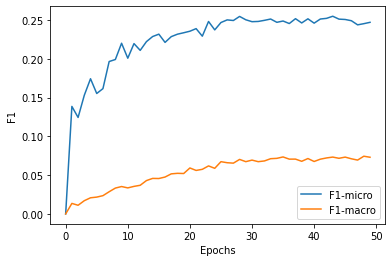

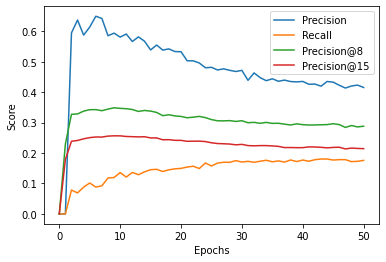

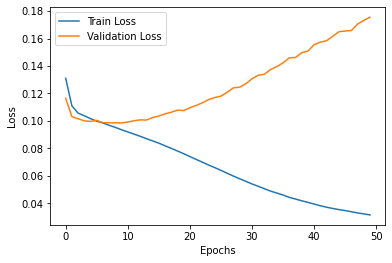

In [0]:

evals = np.asarray(evals)
f1 = evals[:, 1]
data = evals[:, 2] # (b, )
eval_add = evals[:, 3]
train_loss = evals[:, 4]
loss = [data[i][-1] for i in range(len(data))]

f1_macro, precision, recall, acc_8, acc_15 = [], [0], [0], [0], [0]
for e in eval_add:
    f1_macro.append(e[0])
    precision.append(e[1])
    recall.append(e[2])
    acc_8.append(e[3])
    acc_15.append(e[4])

mx = max(f1)
idx = np.argmax(f1)
pkl.dump(loss, open("./loss", "wb"))
pkl.dump(f1, open("./f1", "wb"))
pkl.dump(f1_macro, open("./f1_macro", "wb"))
pkl.dump(recall, open("./recall", "wb"))
pkl.dump(precision, open("./precision", "wb"))
pkl.dump(acc_8, open("./acc_8", "wb"))
pkl.dump(acc_15, open("./acc_15", "wb"))
pkl.dump(train_loss, open("./train_loss", "wb"))

import matplotlib.pyplot as plt
def plot_f1(f1_micro, loss, f1_macro, precision, recall, acc_8, acc_15):
    plt.plot(f1_micro, label="F1-micro")
    plt.plot(f1_macro, label="F1-macro")
    plt.legend() 
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.show()

def plot_iter(f1_micro, loss, f1_macro, precision, recall, acc_8, acc_15):
    plt.plot(precision, label="Precision")
    plt.plot(recall, label="Recall")
    plt.plot(acc_8, label="Precision@8")
    plt.plot(acc_15, label="Precision@15")

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.show()

def plot_loss(train_loss, test_loss):
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss, label="Validation Loss")

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

plot_f1(f1[:100], loss[:100], f1_macro[:100], precision[:100], recall[:100], acc_8[:100], acc_15[:100])
plot_iter(f1[:100], loss[:100], f1_macro[:100], precision[:100], recall[:100], acc_8[:100], acc_15[:100])
plot_loss(train_loss[:100], loss[:100])